In [16]:
# Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Disable JIT Compilation in TensorFlow
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=0'

# Load the dataset
data = pd.read_csv('TSLA.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


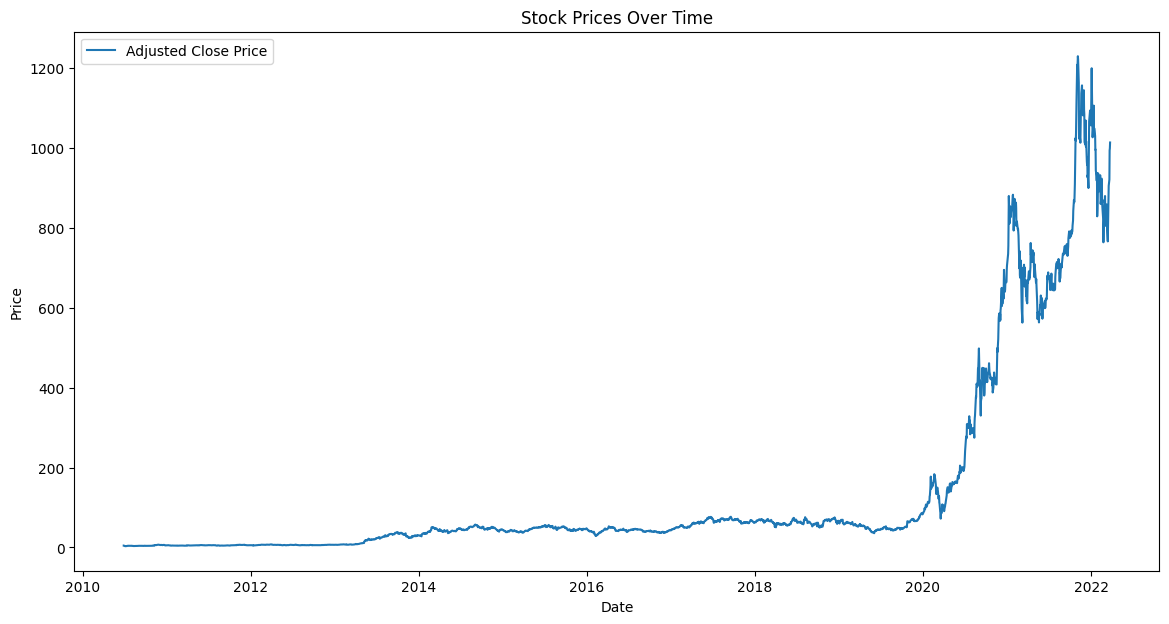

In [17]:


# Check for missing values and drop them
data = data.dropna()

# Prepare the data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Initial Data Exploration
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Adj Close'], label='Adjusted Close Price')
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


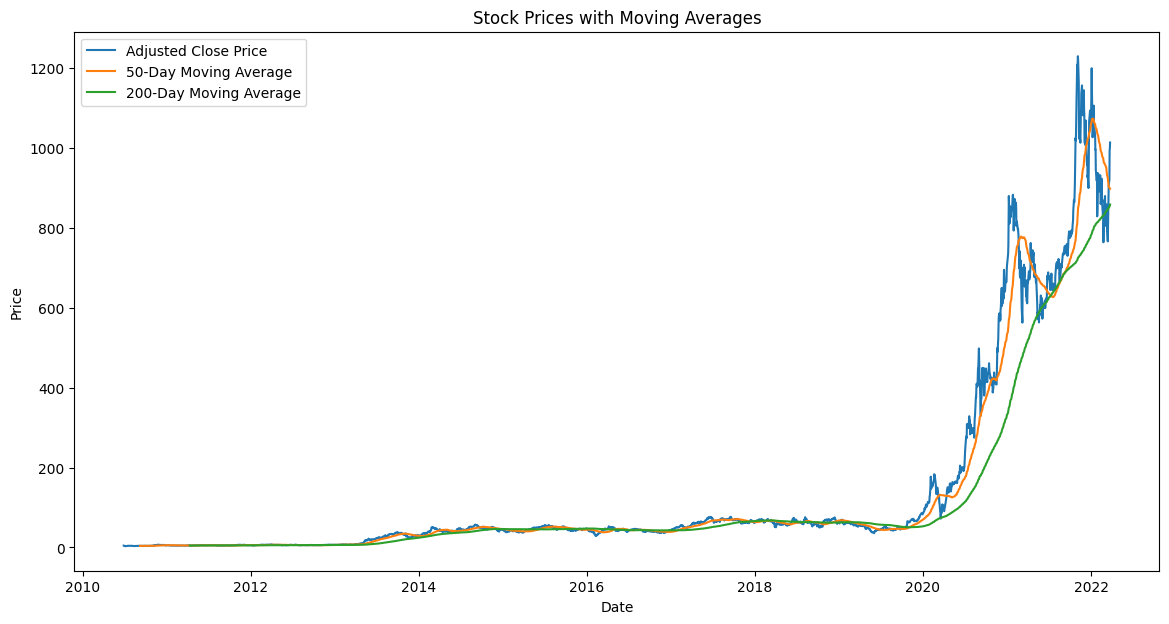

In [29]:
# Moving Average Plot
data['MA50'] = data['Adj Close'].rolling(window=50).mean()
data['MA200'] = data['Adj Close'].rolling(window=200).mean()

plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Adj Close'], label='Adjusted Close Price')
plt.plot(data.index, data['MA50'], label='50-Day Moving Average')
plt.plot(data.index, data['MA200'], label='200-Day Moving Average')
plt.title('Stock Prices with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

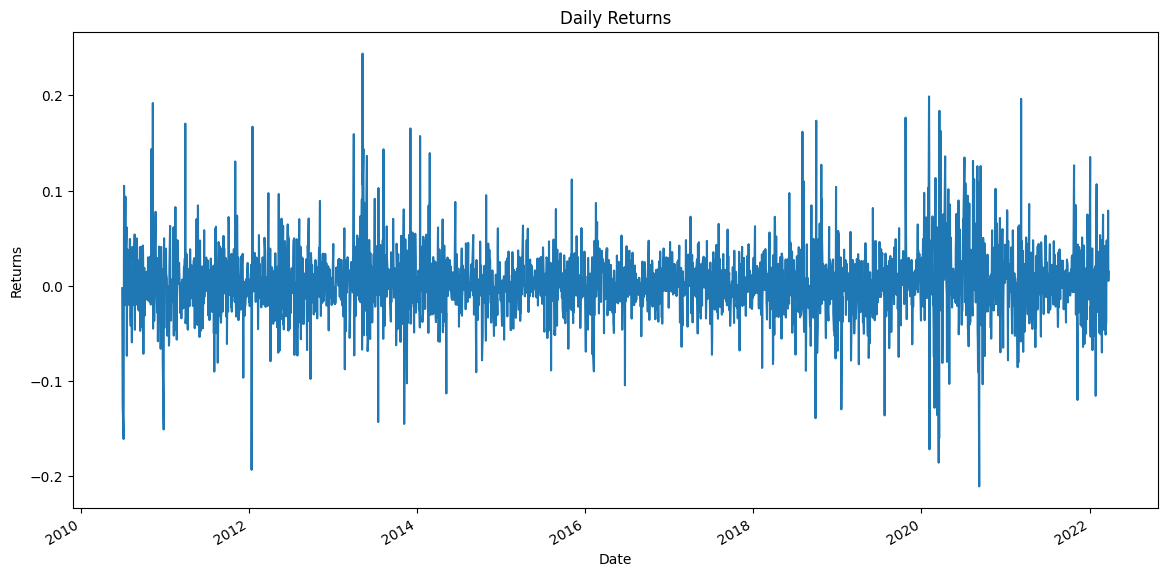

In [30]:
# Rolling Statistics
data['Returns'] = data['Adj Close'].pct_change()

plt.figure(figsize=(14, 7))
data['Returns'].plot()
plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.show()

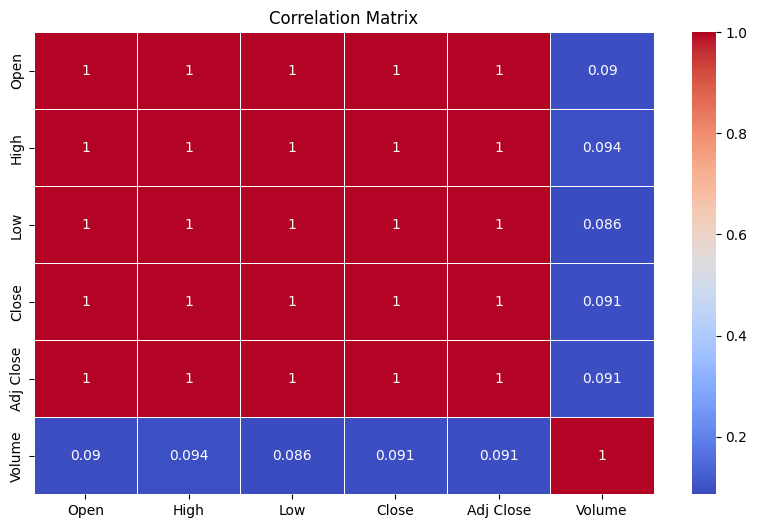

In [18]:

# Correlation Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [19]:

# Feature selection
features = data[['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']]
target = data['Adj Close']

# Normalize the features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, shuffle=False)

# Reshape data for LSTM
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


In [20]:

# LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(1, X_train.shape[1])))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train_lstm, y_train, epochs=50, batch_size=32)
pred_lstm = model_lstm.predict(X_test_lstm).flatten()


Epoch 1/50


/home/kumarguptajit/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1778.7346
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1670.4161
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1085.9860
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 792.0914
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 678.3022
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 601.4128
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 552.3940
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 524.0622
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 481.4326
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 445.5627
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 389.1184
Epoch 12/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 338.5863
Epoch 13/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 246.3015
Epoch 14/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 186.8261
Epoch 15/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

In [21]:


# XGBoost Model
import xgboost as xgb
from sklearn.metrics import mean_squared_error

model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
model_xgb.fit(X_train, y_train)
pred_xgb = model_xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))


In [22]:

# Random Forest Model
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(n_estimators=100)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))


In [23]:

# Calculate RMSE for LSTM
rmse_lstm = np.sqrt(mean_squared_error(y_test, pred_lstm))


In [24]:

# Print RMSE for each model
print(f'RMSE for LSTM: {rmse_lstm}')
print(f'RMSE for XGBoost: {rmse_xgb}')
print(f'RMSE for Random Forest: {rmse_rf}')


RMSE for LSTM: 573.7605433156078
RMSE for XGBoost: 568.709490061067
RMSE for Random Forest: 568.1454307369612


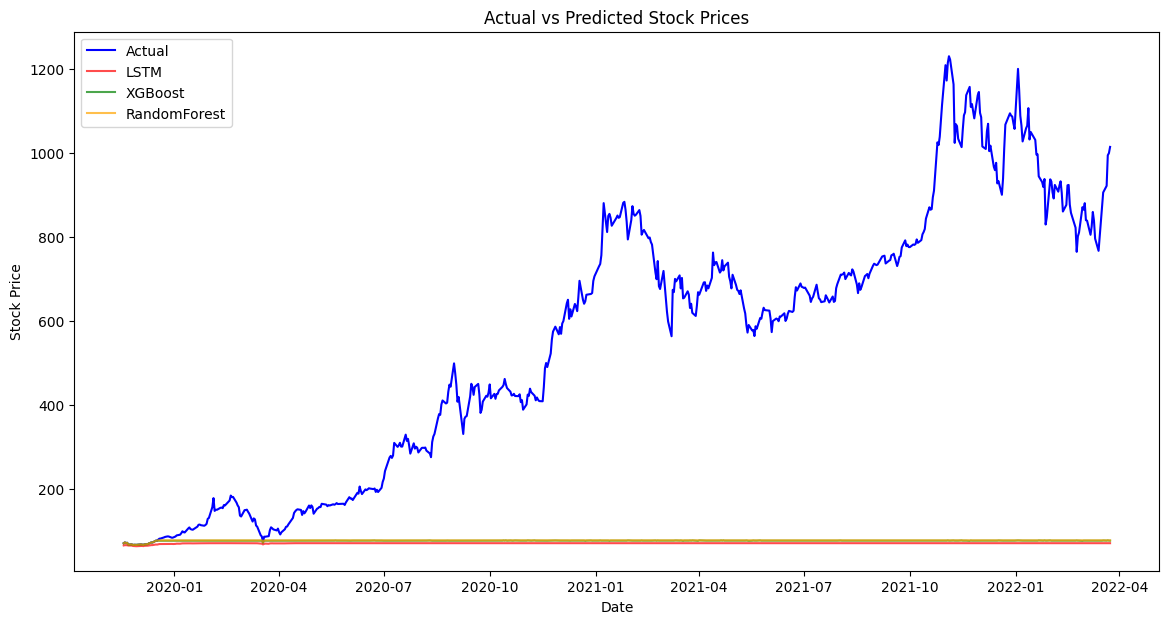

In [25]:

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_test,
    'LSTM': pred_lstm,
    'XGBoost': pred_xgb,
    'RandomForest': pred_rf
}, index=y_test.index)

# Plot actual vs predicted stock prices
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Actual'], label='Actual', color='blue')
plt.plot(results_df.index, results_df['LSTM'], label='LSTM', color='red', alpha=0.7)
plt.plot(results_df.index, results_df['XGBoost'], label='XGBoost', color='green', alpha=0.7)
plt.plot(results_df.index, results_df['RandomForest'], label='RandomForest', color='orange', alpha=0.7)
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


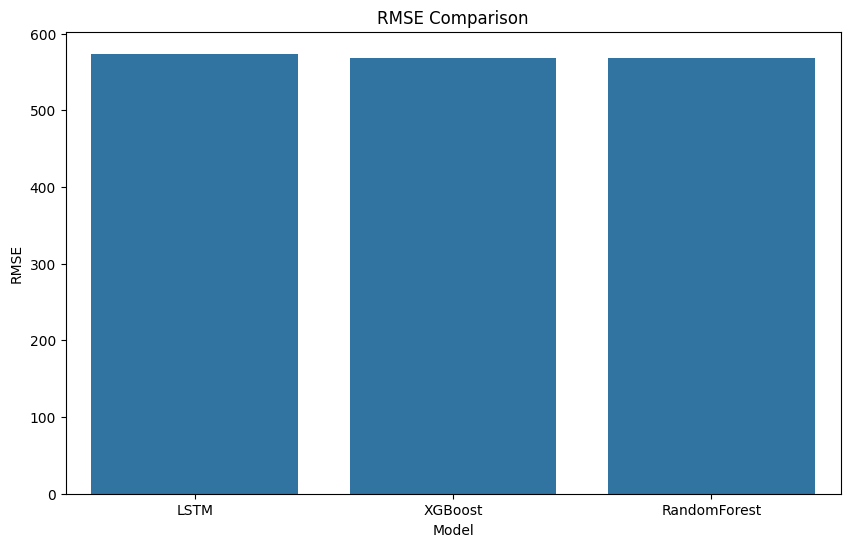

In [26]:

# Plot RMSE comparison
rmse_values = {'Model': ['LSTM', 'XGBoost', 'RandomForest'], 'RMSE': [rmse_lstm, rmse_xgb, rmse_rf]}
rmse_df = pd.DataFrame(rmse_values)

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=rmse_df)
plt.title('RMSE Comparison')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.show()


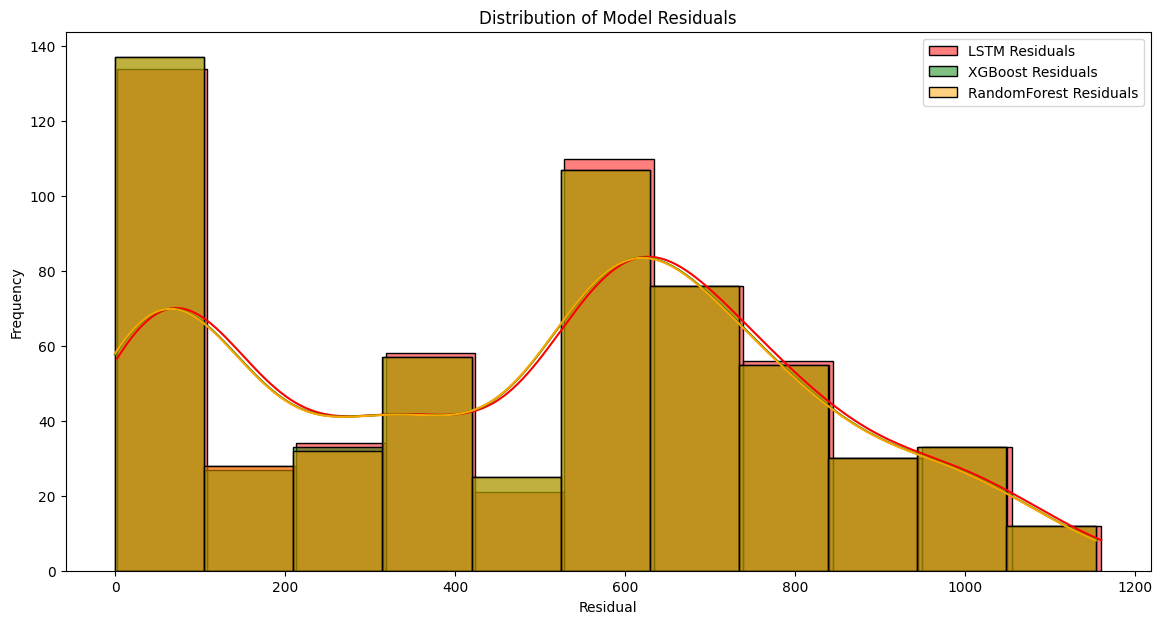

In [27]:

# Model Residuals Distribution
plt.figure(figsize=(14, 7))
sns.histplot(y_test - pred_lstm, kde=True, color='red', label='LSTM Residuals')
sns.histplot(y_test - pred_xgb, kde=True, color='green', label='XGBoost Residuals')
sns.histplot(y_test - pred_rf, kde=True, color='orange', label='RandomForest Residuals')
plt.title('Distribution of Model Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.legend()
plt.show()


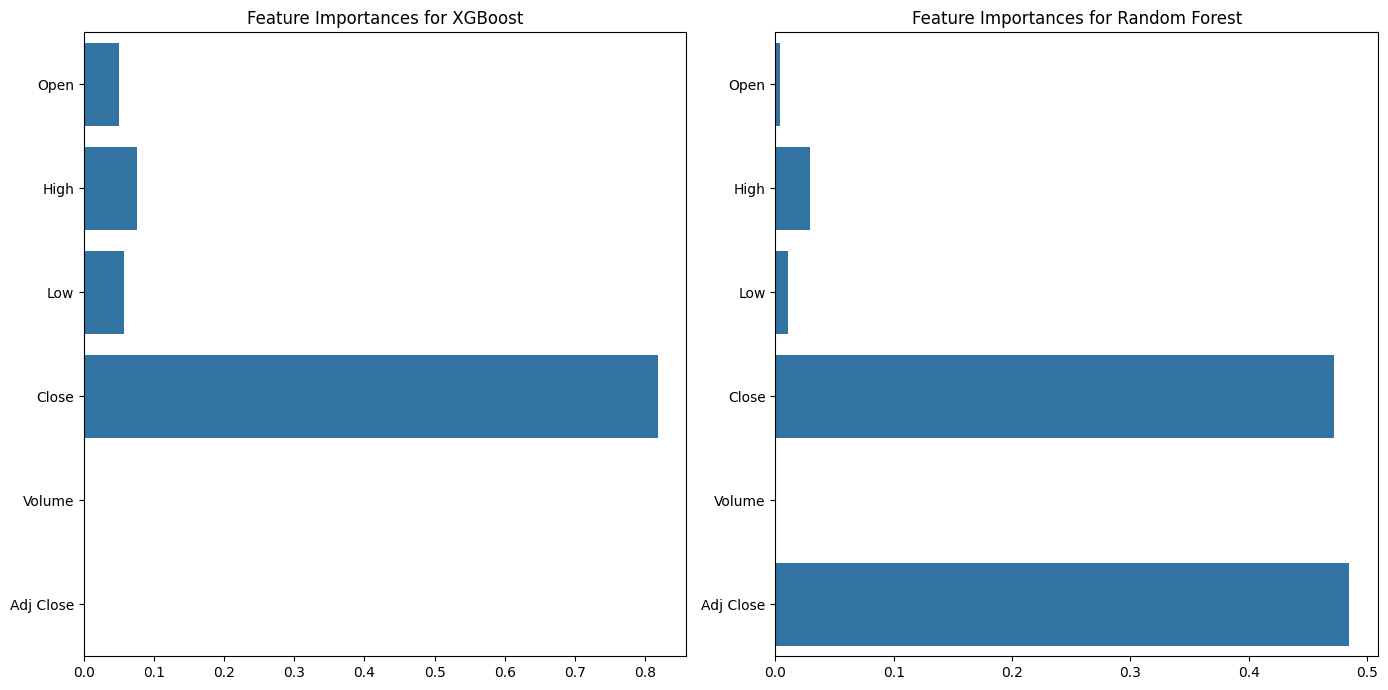

In [31]:
# Feature Importance for XGBoost and RandomForest
xgb_importances = model_xgb.feature_importances_
rf_importances = model_rf.feature_importances_

features_names = ['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close']

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.barplot(x=xgb_importances, y=features_names)
plt.title('Feature Importances for XGBoost')

plt.subplot(1, 2, 2)
sns.barplot(x=rf_importances, y=features_names)
plt.title('Feature Importances for Random Forest')

plt.tight_layout()
plt.show()


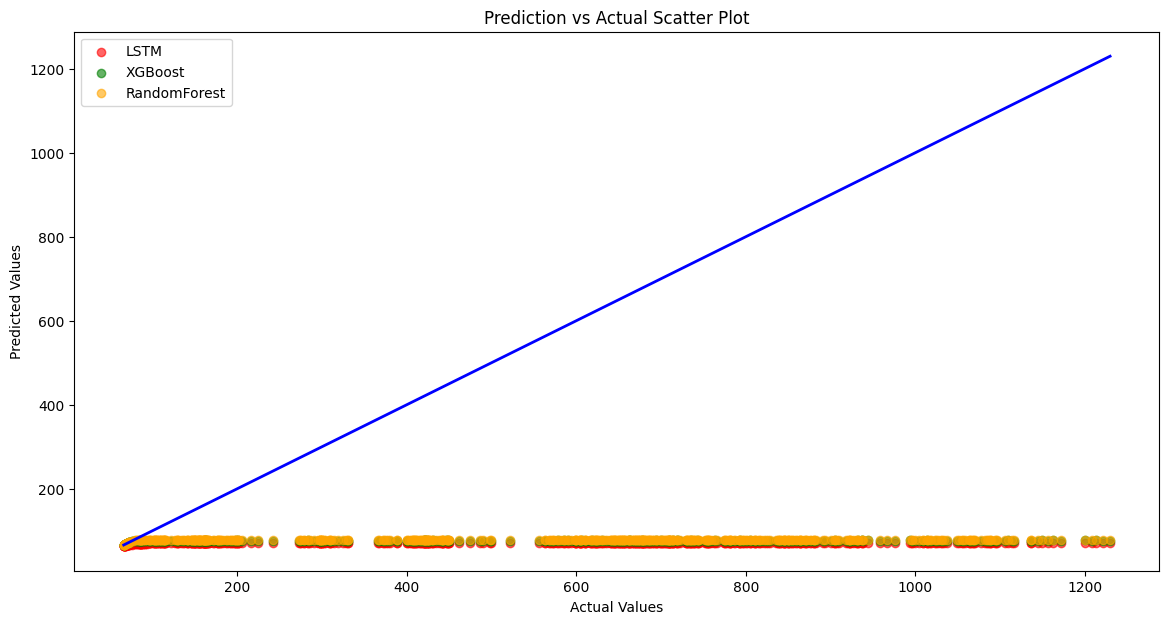

In [32]:

# Prediction vs Actual Scatter Plot
plt.figure(figsize=(14, 7))
plt.scatter(results_df['Actual'], results_df['LSTM'], label='LSTM', color='red', alpha=0.6)
plt.scatter(results_df['Actual'], results_df['XGBoost'], label='XGBoost', color='green', alpha=0.6)
plt.scatter(results_df['Actual'], results_df['RandomForest'], label='RandomForest', color='orange', alpha=0.6)
plt.plot([results_df['Actual'].min(), results_df['Actual'].max()],
         [results_df['Actual'].min(), results_df['Actual'].max()],
         color='blue', lw=2)
plt.title('Prediction vs Actual Scatter Plot')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()


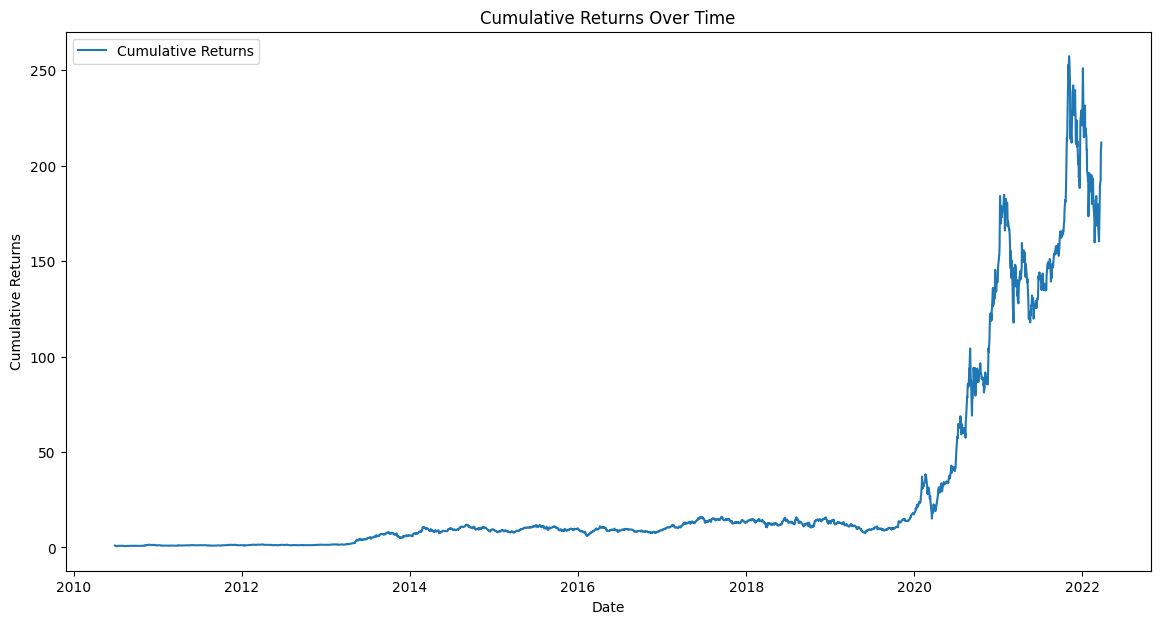

In [33]:

# Cumulative Returns Plot
data['Cumulative Returns'] = (1 + data['Returns']).cumprod()

plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Cumulative Returns'], label='Cumulative Returns')
plt.title('Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


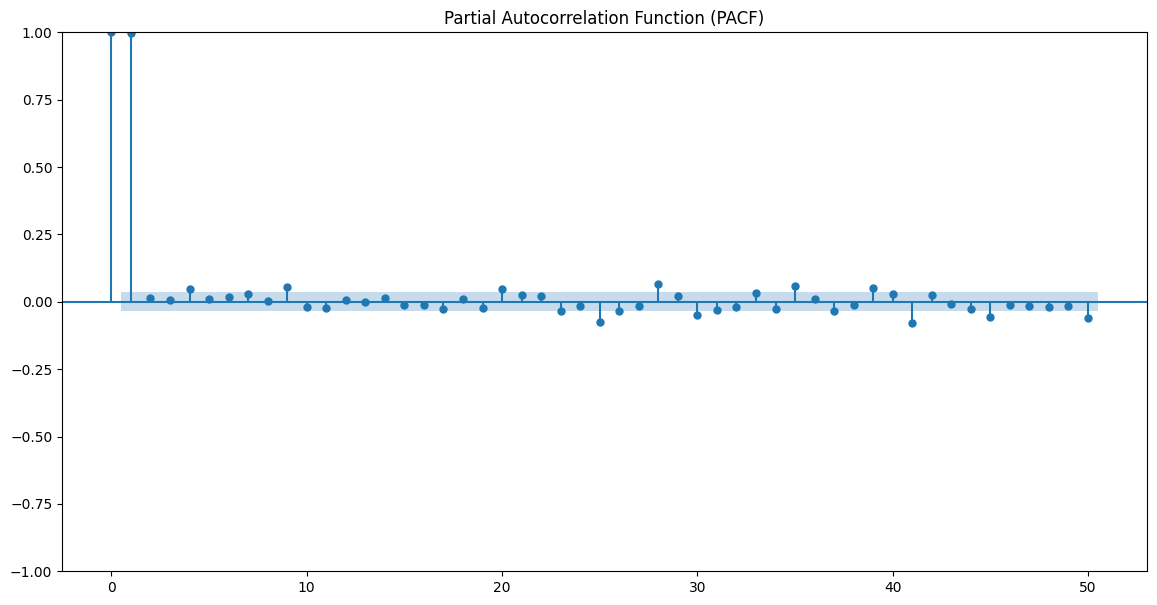

In [36]:

# Partial Autocorrelation Function (PACF) Plot
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(14, 7))
plot_pacf(data['Adj Close'].dropna(), lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()